In [1]:
import pandas as pd
import os
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
from torch import nn
import pytorch_lightning as L
from pytorch_lightning import seed_everything, LightningModule, Trainer
import numpy as np

In [3]:
!pwd

/Users/unchil/PythonProjects/timeSerise


In [4]:
data_path = './data/Metro_Interstate_Traffic_Volume_modify.csv'
df_data = pd.read_csv(data_path, parse_dates=['date_time'], index_col="date_time")  
scaler = MinMaxScaler()
scaler.fit( df_data[['traffic_volume']] )

MinMaxScaler()

In [448]:

class TrafficVolumeDataset(Dataset):
    
    def __init__(self, df_data, data_type , transformer, window_size=480):

        self.type = data_type
        self.transformer = transformer
        # window_size= 480 #(24 Hour * 20 Day)
        self.window_size = window_size
        self.df_data = df_data

        self.data = self.getData()
        
        features = self.data
        target = self.data.traffic_volume
        
        self.x, self.y = [], []


        # 각 시간간격별 예측시  1시간뒤: x = 0 , 2시간뒤: x = 1, 3시간뒤: x = 2 ...
        #
        # for i in range(len(features) - self.window_size - X):
        #     v = features.iloc[ i: (i + window_size) ].values
        #     self.x.append(v)
        #     self.y.append( target.iloc[ i + window_size + x] )

        
        for i in range(len(features) - self.window_size ):
            v = features.iloc[ i: (i + window_size) ].values
            self.x.append(v)
            self.y.append( target.iloc[ i + window_size ] )



        # Many to Many output_size = 6
       # for i in range(len(features) - self.window_size - 6 + 1):
       #     self.x.append( features.iloc[ i: (i + window_size) ].values )
       #     a = target[  i + window_size :  i + window_size + 6].values.reshape(-1, 1)
       #     self.y.append( a)
    

    def getData(self):

        if self.type == 'train':
            df_data = self.df_data.loc['2016-01-01':'2017-12-31']
            df_data.traffic_volume =  self.transformer.transform(df_data[['traffic_volume']])
            return df_data
        elif self.type == 'valid':
            df_data = self.df_data.loc['2018-01-01':'2018-06-30']
            df_data.traffic_volume =  self.transformer.transform(df_data[['traffic_volume']])
            return df_data
        elif self.type == 'test': 
            df_data = self.df_data.loc['2018-07-01':'2018-12-31']
            df_data.traffic_volume =  self.transformer.transform(df_data[['traffic_volume']])
            return df_data
        else:
            df_data = self.df_data
            df_data.traffic_volume =  self.transformer.transform(df_data[['traffic_volume']])
            return df_data
    
    
    def __getitem__(self, index):
        
        x = self.x[index].astype(np.float32)
        y = self.y[index].astype(np.float32)
        return x, y
    
        
        
    
    def __len__(self):
        
        return len(self.x)

In [406]:

window_size = 480
input_size =17
batch_size=50
learning_rate=0.0001
log_path = os.getcwd()
device = torch.device("mps") if torch.backends.mps.is_available() else  torch.device("cpu")
NUM_WORKERS = os.cpu_count()
print(f'Device:{device}, Number of workers:{NUM_WORKERS}\nCurrent Dir:{log_path}')

Device:mps, Number of workers:8
Current Dir:/Users/unchil/PythonProjects/timeSerise


In [449]:
test_data = TrafficVolumeDataset(df_data=df_data, data_type='test', transformer=scaler,  window_size=window_size)

#let's loop it over single iteration and print the shape and also data
for i, (features,targets) in enumerate(test_data):
    print("Size of the features",features.shape)
    print("Printing features:\n", features)
    print("Size of the targets",targets.shape)
    print("Printing targets:\n", targets)
    break
     

/var/folders/wp/qtpm72194czff6rn4dry0c7c0000gn/T/ipykernel_4250/2521500796.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data.traffic_volume =  self.transformer.transform(df_data[['traffic_volume']])


Size of the features (480, 17)
Printing features:
 [[0.1804945  1.         0.         ... 0.         0.         1.        ]
 [0.11648352 1.         0.         ... 0.         0.         1.        ]
 [0.09656593 1.         0.         ... 0.         0.         1.        ]
 ...
 [0.4287088  1.         0.         ... 0.         1.         0.        ]
 [0.41648352 1.         0.         ... 0.         1.         0.        ]
 [0.27884614 1.         0.         ... 0.         0.         1.        ]]
Size of the targets ()
Printing targets:
 0.16964285


In [ ]:
#num_worker = 1
train_loader = DataLoader( TrafficVolumeDataset(df_data=df_data, data_type='train', transformer=scaler), batch_size=batch_size)
valid_loader = DataLoader( TrafficVolumeDataset(df_data=df_data, data_type='valid', transformer=scaler), batch_size=batch_size)
test_loader = DataLoader( TrafficVolumeDataset(df_data=df_data, data_type='test', transformer=scaler), batch_size=batch_size)

print(f'train_loader:{len(train_loader)}, valid_loader:{len(valid_loader)}, test_loader:{len(test_loader)}')

In [437]:
class TrafficVolumePrediction(L.LightningModule):
    def __init__(self, input_size=input_size, output_size=1, hidden_dim=10, n_layers=2, lr=learning_rate, window_size=window_size):
 
        super(TrafficVolumePrediction, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, bidirectional=False, batch_first=True)
        self.fc = nn.Linear(hidden_dim * window_size, output_size)
        self.loss = nn.MSELoss()
        self.flatten = nn.Flatten()
        self.learning_rate = lr

    

    def forward(self, x):
        
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)    
        lstm_out, (hidden, cell) = self.lstm(x, hidden)
        out = self.flatten(lstm_out)
        out = self.fc(out)

        return out

    
    
    def init_hidden(self, batch_size):   
        hidden_state = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        cell_state = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        hidden = (hidden_state, cell_state)
        return hidden

    
    
    def configure_optimizers(self):
        return {'optimizer': torch.optim.Adam(params=self.parameters(), lr = self.learning_rate) }

    def training_step(self, train_batch, batch_idx):
        features, targets = train_batch
        output = self(features) 
        output = output.view(-1)
        loss = self.loss(output, targets)
        self.log('train_loss', loss, prog_bar=True)
        return {"loss": loss}
        
    
    def validation_step(self, val_batch, batch_idx):
        features, targets = val_batch
        output = self(features) 
        output = output.view(-1)
        loss = self.loss(output, targets)
        self.log('val_loss', loss, prog_bar=True)




In [441]:
model = TrafficVolumePrediction().to(device)
model

TrafficVolumePrediction(
  (lstm): LSTM(17, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=4800, out_features=1, bias=True)
  (loss): MSELoss()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [ ]:
trainer = L.Trainer( fast_dev_run=True, accelerator='mps', devices=1)

In [ ]:
trainer = L.Trainer( default_root_dir=log_path, precision="16", max_epochs=20, accelerator='mps', devices=1)

In [ ]:
trainer.fit( model, train_loader,  valid_loader)

In [ ]:
#%load_ext tensorboard
#%tensorboard --logdir lightning_logs/

In [444]:
PATH = './lightning_logs/version_7/checkpoints/epoch=19-step=6840.ckpt'
model = TrafficVolumePrediction.load_from_checkpoint(PATH).to(device)
model.eval()

TrafficVolumePrediction(
  (lstm): LSTM(17, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=4800, out_features=1, bias=True)
  (loss): MSELoss()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [445]:
predicted_result, actual_result = [], []

for i, (features,targets) in enumerate(test_loader):

    features = features.to(device)
    targets = targets.to(device)

    result = model(features)
    predicted_result.extend(result.view(-1).tolist())
    actual_result.extend(targets.view(-1).tolist())

In [446]:
actual_predicted_df = pd.DataFrame(data={"actual":actual_result, "predicted": predicted_result})
inverse_transformed_values = scaler.inverse_transform(actual_predicted_df)
actual_predicted_df["actual"] = inverse_transformed_values[:,[0]]
actual_predicted_df["predicted"] = inverse_transformed_values[:,[1]]

actual_predicted_df.index = pd.date_range('2018-07-21 00:00:00', '2018-09-30 23:00:00', freq='1h')

actual_predicted_df

,actual,predicted
2018-07-21 11:00:00,4418.000116,4264.655619
2018-07-21 12:00:00,4505.000138,4628.223085
2018-07-21 13:00:00,4644.000049,4496.355114
2018-07-21 14:00:00,4795.999823,4270.643740
2018-07-21 15:00:00,4674.000101,4268.241549
...,...,...
2018-09-30 19:00:00,3543.000033,2761.417675
2018-09-30 20:00:00,2780.999916,2496.889825
2018-09-30 21:00:00,2158.999898,2304.343312
2018-09-30 22:00:00,1449.999968,1755.674888


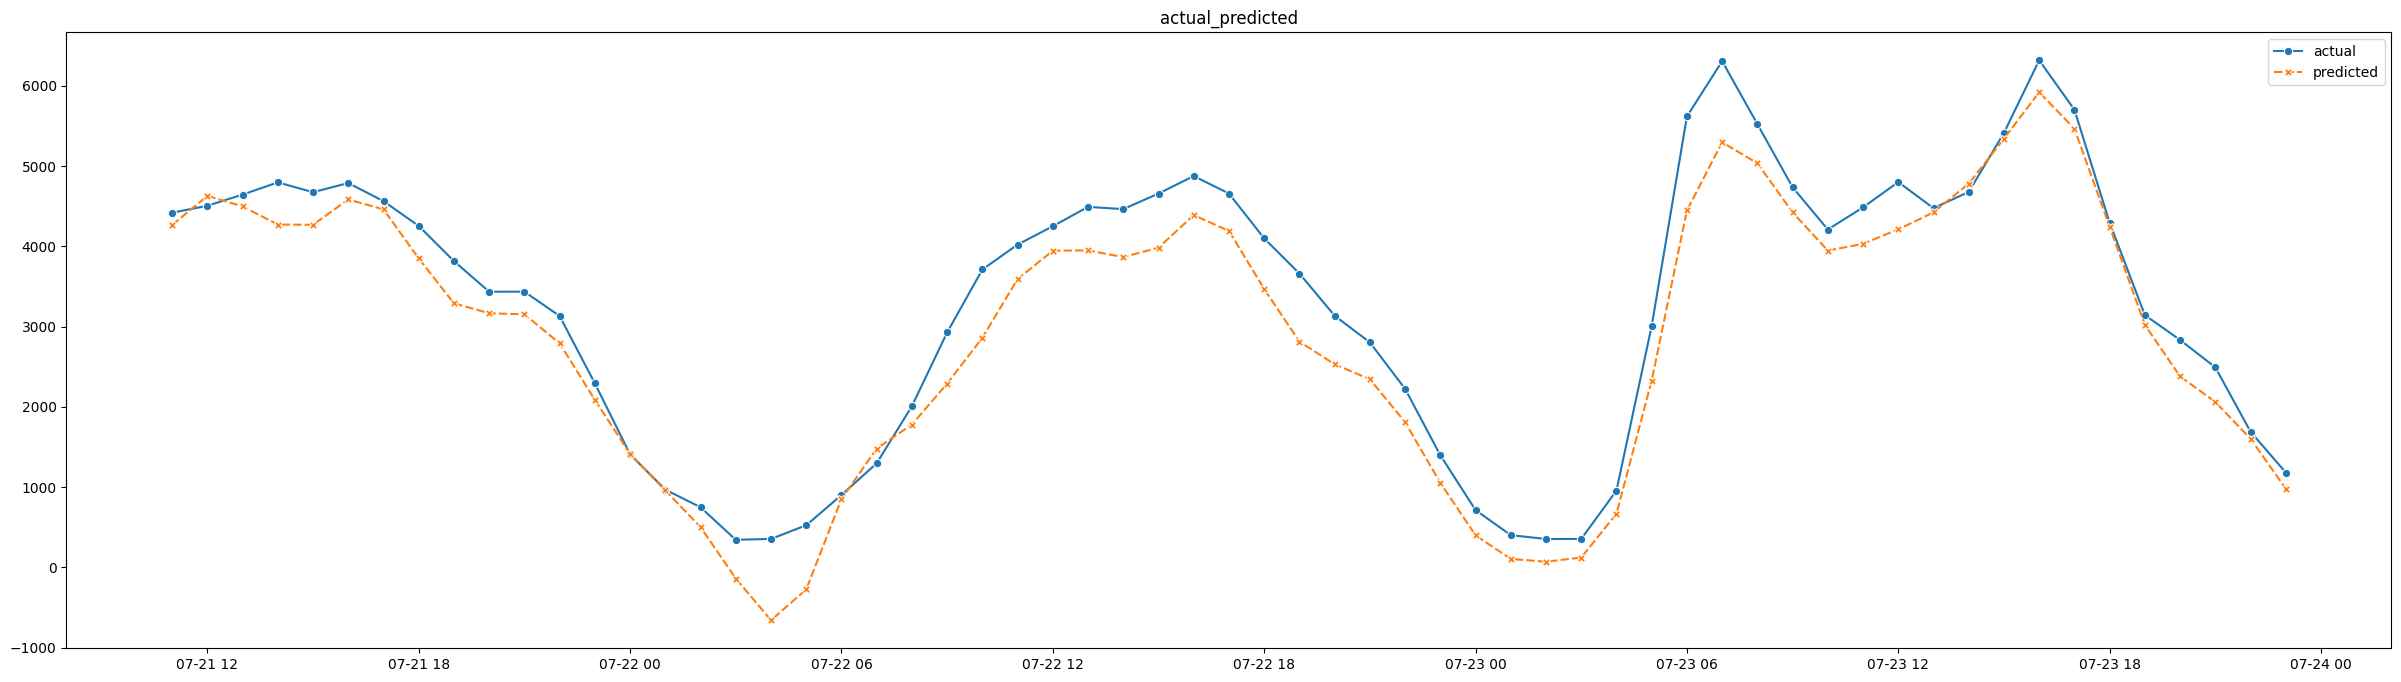

In [447]:
import matplotlib.pyplot as plt
import seaborn as sns


data = actual_predicted_df.loc['2018-07-20':'2018-07-23']

fig = plt.figure(figsize=(30,8))
axs = fig.subplot_mosaic([['actual_predicted']])
axs['actual_predicted'].set_title('actual_predicted')
sns.lineplot( data = data,  markers=True, ax=axs['actual_predicted'] )

plt.show()